In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, invgamma
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

from utils import filter_data, add_logarithmic_variables, plot_correlations

In [4]:
# Get root directory
root_dir = os.path.dirname(os.path.abspath(''))
# read data
data = pd.read_csv(
    os.path.join(root_dir, 'data', 'CHC_base_anonimizada09-09-2021.csv')
    )
# filter data
data_filter = filter_data(data)
# add logarithmic variables
add_logarithmic_variables(data_filter)
# plot correlations
variables_interest = [
    'anios_en_calle',
    'hombre',
    'minoria_raza',
    'minoria_lgbt',
    'discapacidad',
    'enfermedad',
    'contacto_familia',
    'recibe_ayuda',
    'anios_educacion',
    'consume_drogas',
    'edad_promedio_inicio_consumo',
    'edad'
]

# plot_correlations(
#     data_filter,
#     variables_interest,
#     save=False
#     )

In [4]:
y = data["anios_en_calle"].values.reshape(-1, 1)
X = np.hstack((np.ones((len(y), 1)), data[[
                                            "hombre",
                                            "minoria_raza",
                                            "minoria_lgbt",
                                            "discapacidad",
                                            "enfermedad",
                                            "contacto_familia",
                                            "recibe_ayuda",
                                            "anios_educacion",
                                            "consume_drogas",
                                            "edad_promedio_inicio_consumo",
                                            "edad"
                                            ]].values))


In [5]:
k = X.shape[1]
N = X.shape[0]

# prior hyperparameters
B0 = 1000 * np.eye(k)
B0i = np.linalg.inv(B0)
b0 = np.zeros(k)
a0 = 0.001
d0 = 0.001
sigma20 = 10

In [ ]:
# define model
with pm.Model() as model:
    # prior distributions
    beta = pm.MvNormal("beta", mu=b0, cov=B0)
    sigma2 = pm.InverseGamma("sigma2", alpha=a0, beta=d0)

    # likelihood
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sd=pm.math.sqrt(sigma2), observed=y)

    # posterior sampling
    trace = pm.sample(draws=10000, tune=5000, chains=4)
    betasG = trace["beta"]
    varsG = trace["sigma2"]


In [ ]:
# posterior summary
az.summary(trace, var_names=["beta", "sigma2"])

# trace plot
az.plot_trace(trace, var_names=["beta", "sigma2"])

# autocorrelation plot
az.plot_autocorr(trace, var_names=["beta", "sigma2"])

# diagnostic plots
az.plot_forest(trace, var_names=["beta"], combined=True)
az.plot_forest(trace, var_names=["sigma2"], combined=True)
az.plot_geweke(trace, var_names=["beta", "sigma2"])
az.plot_ess(trace, var_names=["beta", "sigma2"])

In [ ]:
### Interpretacion Resultados
# var2: ser hombre 12.95% mas anios en la calle
# var3: ser minoria raza 16.37% mas anios en la calle
# var4: no es estadisticamente relevante
# var5: no es estadisticamente relevante
# var6: no es estadisticamente relevante
# var7: no tener contacto con familia 15.04% mas anios en la calle
# var8: no es estadisticamente relevante
# var9: tener bachillerato 24.85% mas de anios en la calle
# var10: si consume drogas actualmente 94.26% anios en en la calle
# var11: un anio mas de madurez en el inicio de consumo de drogas 1.80% menos de anios en la calle
# var12: un anio mas de edad 3.14% mas de anios en la calle

# Bayesian Linear Regression with PyMC3
https://towardsdatascience.com/implementing-bayesian-linear-regression-9375a9994f98

In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

import aesara
import pymc3 as pm

# ignore warning
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
np.random.seed(16)

# Parameters
size = 1000
beta_0, beta_1 = 1, 2

# Simulate outcome variable
x = np.random.random(size)
y = beta_0 + beta_1 * x + np.random.randn(size)
data = pd.DataFrame(dict(x=x, y=y))

In [3]:
X = sm.add_constant(data['x'])
Y = data['y']
reg = sm.OLS(Y, X)

model_freq = reg.fit()
print(model_freq.summary())

beta_0_ols, beta_1_ols = model_freq.params
print(f'Intercept: {beta_0_ols}')
print(f'Slope: {beta_1_ols}')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     336.4
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           5.51e-65
Time:                        21:53:55   Log-Likelihood:                -1448.9
No. Observations:                1000   AIC:                             2902.
Df Residuals:                     998   BIC:                             2912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9862      0.064     15.348      0.0

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, x, Intercept]
NUTS: [sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.8794585315816282, but should be close to 0.8. Try to increase the number of tuning steps.


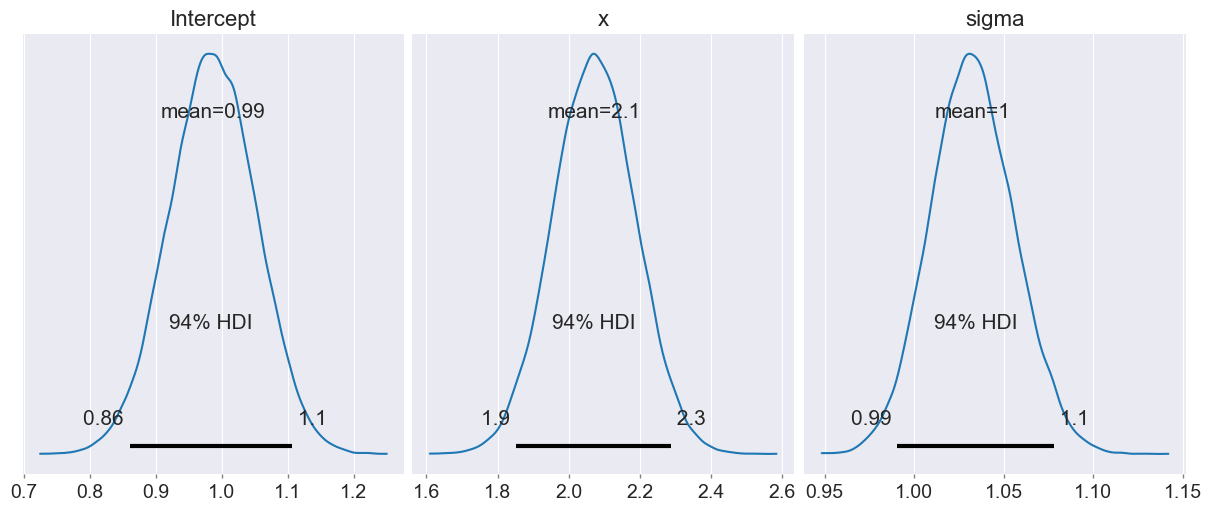

In [4]:
# Given your data, how your coefficients is going to be distributed
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('x', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)

    # Estimate of mean
    mu = intercept + slope * x
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    trace = pm.sample(10000, step)
pm.plot_posterior(trace, figsize = (12, 5));

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, x, Intercept]
NUTS: [sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 28 seconds.


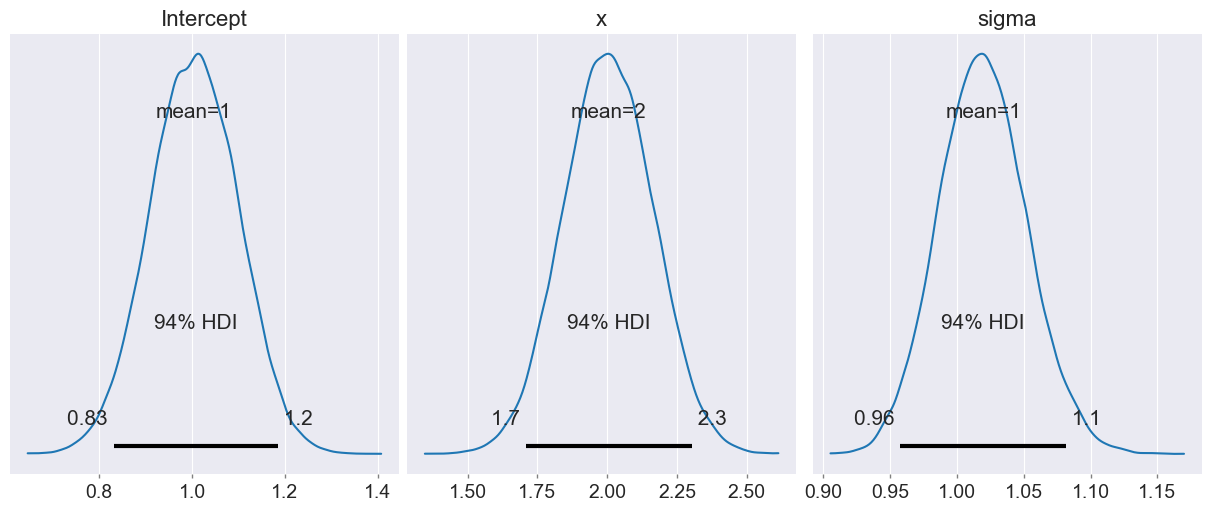

In [5]:
no_data = 500
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('x', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)

    # Estimate of mean
    np.random.seed(16)
    pos_random = np.random.choice(np.arange(len(x)), size=no_data)
    x_sample = x[pos_random]
    y_sample = y[pos_random]
    mu = intercept + slope * x_sample
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sample)

    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    trace_500 = pm.sample(10000, step)
pm.plot_posterior(trace_500, figsize = (12, 5));

<bound method Axes.legend of <Axes: xlabel='x', ylabel='y'>>

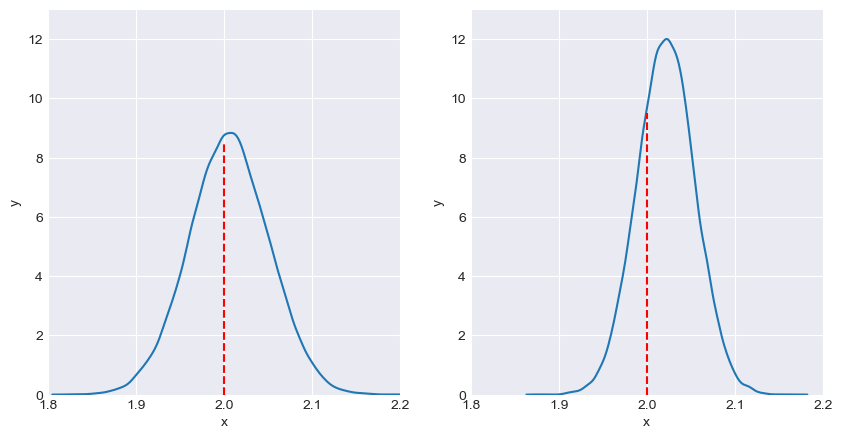

In [6]:
x_pred = 0.5
bayes_prediction_500 = trace_500['Intercept'] + trace_500['x'] * x_pred
bayes_prediction = trace['Intercept'] + trace['x'] * x_pred

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(bayes_prediction_500, label = 'Bayes Posterior Prediction', ax=axs[0])
axs[0].vlines(1+2*x_pred, ymin = 0, ymax = 8.5, label = 'OLS Prediction', colors = 'red', linestyles='--')
axs[0].set_xlim(1.8, 2.2)
axs[0].set_ylim(0, 13)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction', ax=axs[1])
axs[1].vlines(1+2*x_pred, ymin = 0, ymax = 9.5, label = 'OLS Prediction', colors = 'red', linestyles='--')
axs[1].set_xlim(1.8, 2.2)
axs[1].set_ylim(0, 13)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend

## Updating priors Bayesian regression models

In [7]:
# Initialize random number generator
np.random.seed(16)

# True parameter values
beta0_true = 5
beta1_true = 7
beta2_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.5

# Simulate outcome variable
Y = beta0_true + beta1_true * X1 + beta2_true * X2 + np.random.randn(size)

In [8]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=12, sigma=1)
    beta2 = pm.Normal("beta2", mu=18, sigma=1)

    # Expected value of outcome
    mu = beta0 + beta1 * X1 + beta2 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [ ]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.distributions.Interpolated(param, x, y)

traces = [trace]
for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = beta0_true + beta1_true * X1 + beta2_true * X2 + np.random.randn(size)

    model = pm.Model()
    with model:
        # Priors are posteriors from previous iteration
        beta0 = from_posterior("beta0", trace["beta0"])
        beta1 = from_posterior("beta1", trace["beta1"])
        beta2 = from_posterior("beta2", trace["beta2"])

        mu = beta0 + beta1 * X1 + beta2 * X2
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        # trace = pm.sample(draws=1000, tune=10000)
        trace = pm.sample(5000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8956883273316969, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.696520013703111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6249327645828838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5868244571334549, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [10]:
# - textos de Econometria tipo Wooldridge.
# - La técnica para modelos lineales es mínimos cuadrados en dos etapas
# - para modelos no lineales, normalmente es verosimilitud conjunta, mira el texto de Greenberg la parte de endogeneidad

# Basic example
https://www.kaggle.com/code/billbasener/bayesian-linear-regression-in-pymc3/notebook

In [11]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 1000

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

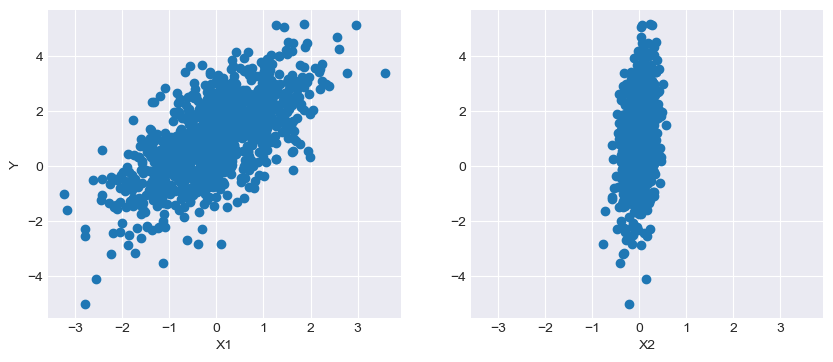

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [13]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=100)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [14]:
with basic_model:
    # draw 5000 posterior samples
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


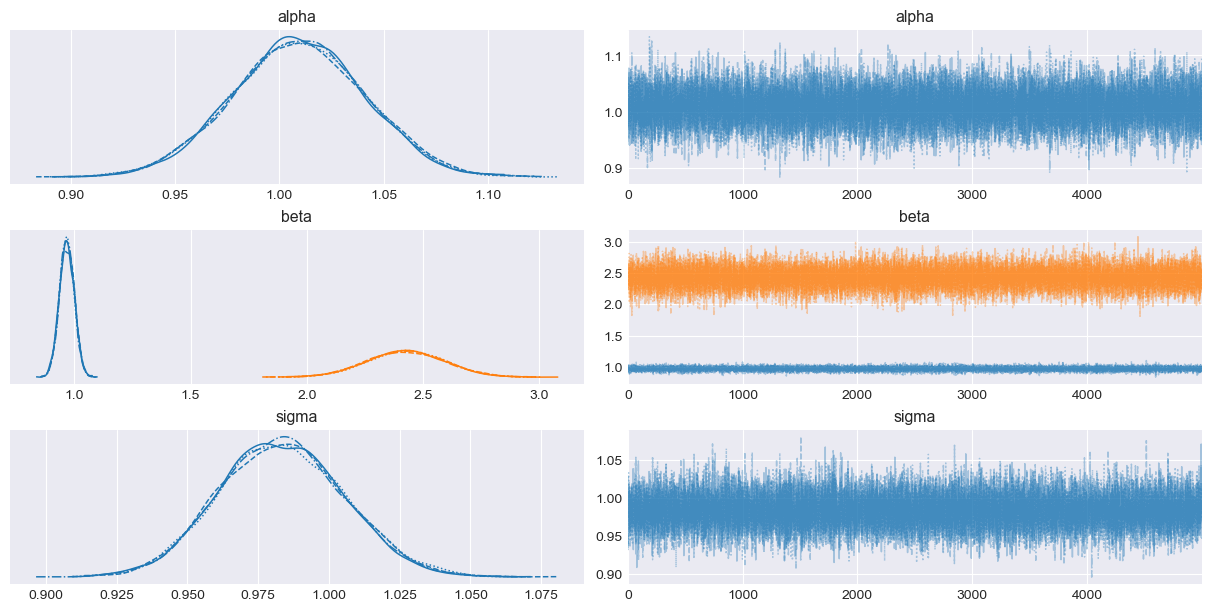

In [15]:
pm.traceplot(trace);

In [16]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.01,0.03,0.95,1.07,0.0,0.0,33858.0,15165.0,1.0
beta[0],0.97,0.03,0.91,1.03,0.0,0.0,32769.0,15563.0,1.0
beta[1],2.43,0.16,2.12,2.74,0.0,0.0,35303.0,15185.0,1.0
sigma,0.98,0.02,0.94,1.02,0.0,0.0,31621.0,15056.0,1.0


In [36]:
# trace to df
trace_betas = pd.DataFrame(trace['beta'], columns=['beta0', 'beta1'])
trace_alphasigma = pd.DataFrame({'alpha': trace['alpha'], 'sigma': trace['sigma']})

<Figure size 900x700 with 0 Axes>

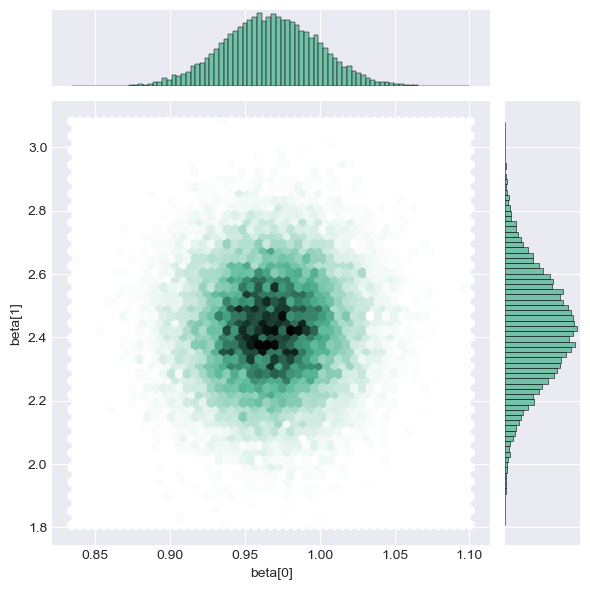

<Figure size 900x700 with 0 Axes>

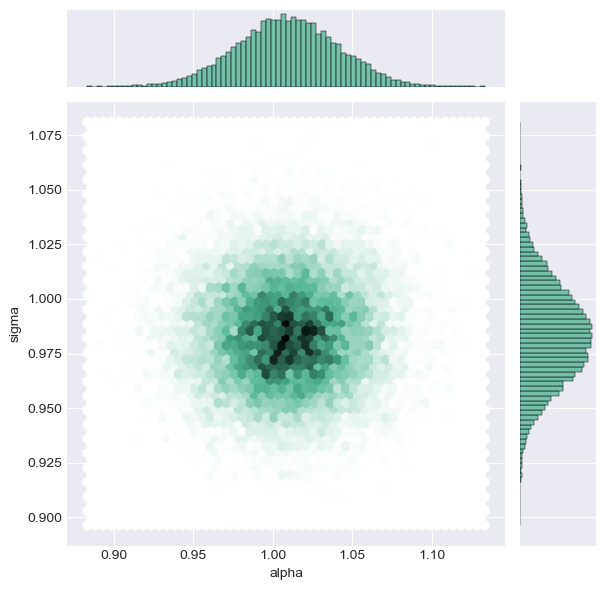

In [37]:
import seaborn as sns
plt.figure(figsize=(9,7))
sns.jointplot(data=trace_betas, x='beta0', y='beta1', kind="hex", color="#4CB391")
plt.xlabel("beta[0]")
plt.ylabel("beta[1]");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(data=trace_alphasigma, x='alpha', y='sigma', kind="hex", color="#4CB391")
plt.xlabel("alpha")
plt.ylabel("sigma");
plt.show()